---
title: 10.11 学习率调度器
date: 2024-8-8 16:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 11 学习率调度器

- 调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

    - 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要. 直观地说，这是最不敏感与最敏感方向的变化量的比率。

    - 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。简而言之，我们希望速率衰减，但要比$O(t^{-\frac12})$慢，这样能成为解决凸问题的不错选择。

    - 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式，又关系到它们最初的演变方式。这被戏称为预热（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。

    - 最后，还有许多优化变体可以执行周期性学习率调整。

## 11.1 一个简单的问题

- 使用一个LeNet:

In [4]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*5*5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # train_loss, train_acc, num_examples
        for i,(X,y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[2]
                if (i+1) % 50 == 0:
                    animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1,(None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')


- 如果使用默认设置，调用此算法会发生什么。
- 例如设学习率为0.3并训练30次迭代。留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。两条曲线之间的间隙表示过拟合。

train loss 0.163, train acc 0.937, test acc 0.892


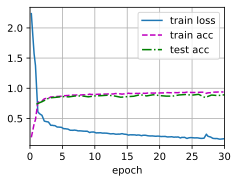

In [7]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 11.2 学习率调度器

- 我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。例如，以动态的方式来响应优化的进展情况。
- 我们应该定义一个调度器。当调用更新次数时，它将返回学习率的适当值。将学习率设置为$\eta = \eta_ 0(t+1)^{-\frac12}$

learning rate is now 0.10


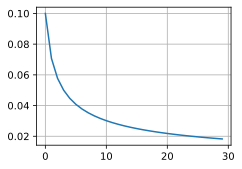

In [8]:
lr=0.1
trainer.param_groups[0]['lr'] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

class SquareRootScheduler:
    def __init__(self, lr=0.1) -> None:
        self.lr = lr
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1, -0.5)
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 看看加入调度器后的结果。

train loss 0.270, train acc 0.902, test acc 0.883


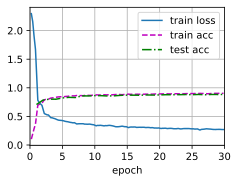

In [9]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

- 比以前好一些：曲线比以前更加平滑，并且过拟合更小了。遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 11.3 策略

- 常用的策略：
    - 多项式衰减
    - 分段常数表
    - 余弦调度
- 在某些问题上，最好在使用较高的学习率之前预热优化器。

### 11.3.1 单因子调度器
- 多项式衰减的一种替代方案是乘法衰减，即$\eta_ {t+1} \leftarrow \eta_t \cdot \alpha$，其中$\alpha \in (0, 1)$.
- 为了防止学习率衰减到一个合理的下界之下，更新方程经常修改为$\eta_ {t+1} \leftarrow \max(\eta_{min}, \eta_t \cdot \alpha)$.

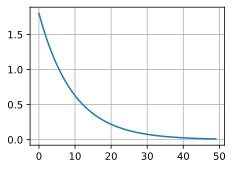

In [12]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1) -> None:
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr
    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### 11.3.2 多因子调度器
- 训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。具体地说，给定一组降低学习率的时间点，例如s={5,10,20}，每当$t \in s$时，降低$\eta_ {t+1} \leftarrow \eta_t \cdot \alpha$. 假设每步中的值减半，我们可以按如下方式实现这一点。

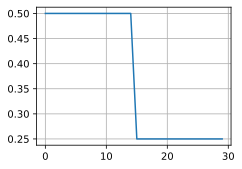

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr
d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler) for _ in range(num_epochs)])

- 这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。

train loss 0.191, train acc 0.928, test acc 0.899


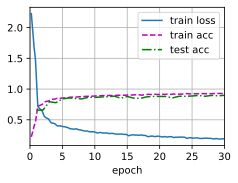

In [14]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### 11.3.3 余弦调度器

- 余弦调度器是一种启发式算法。它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间.
    $$\eta_ t = \eta_ T + \frac{\eta_ 0 - \eta_ T}{2}(1 + \cos(\frac{\pi t}{T}))$$

    - $\eta_ 0$是初始学习率，$\eta_ T$是最终学习率.

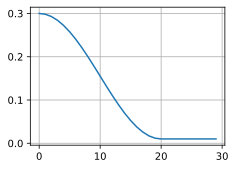

In [15]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0) -> None:
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 在计算机视觉的背景下，这个调度方式可能产生改进的结果。但请注意，如下所示，这种改进并不一定成立。

train loss 0.195, train acc 0.929, test acc 0.895


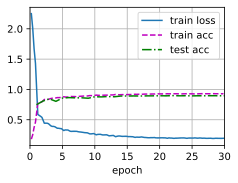

In [16]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### 11.3.4 预热

- 某些情况下，初始化参数不足以得到良好的解。这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。对此，一方面，我们可以选择一个足够小的学习率，从而防止一开始发散，然而这样进展太缓慢。另一方面，较高的学习率最初就会导致发散。

- 解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。为了简单起见，通常使用线性递增。这引出了如下表所示的时间表。

In [17]:
scheduler = CosineScheduler(max_update=20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

AttributeError: 'CosineScheduler' object has no attribute 'base_lr'

- 观察前5个迭代轮数的性能，网络最初收敛得更好。

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

- 预热阶段限制了非常深的网络中参数的发散程度。这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。